This notebook will be collected automatically at **6pm on Monday** from `/home/data_scientist/assignments/Week11` directory on the course JupyterHub server. If you work on this assignment on the course Jupyterhub server, just make sure that you save your work and instructors will pull your notebooks automatically after the deadline. If you work on this assignment locally, the only way to submit assignments is via Jupyterhub, and you have to place the notebook file in the correct directory with the correct file name before the deadline.

1. Make sure everything runs as expected. First, restart the kernel (in the menubar, select `Kernel` → `Restart`) and then run all cells (in the menubar, select `Cell` → `Run All`).
2. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed by the autograder.
3. Do not change the file path or the file name of this notebook.
4. Make sure that you save your work (in the menubar, select `File` → `Save and CheckPoint`)

## Problem 11.3. General Linear Models

In this problem, we will use a general linear model to fit a linear model that predicts `AirTime` from `Distance`.

![](https://raw.githubusercontent.com/UI-DataScience/info490-sp16/master/Week11/assignments/images/general_linear_models.png)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

from nose.tools import assert_equal, assert_is_instance, assert_true
from numpy.testing import assert_array_almost_equal, assert_almost_equal

We use the [airline on-time performance data](http://stat-computing.org/dataexpo/2009/). For simplicity, we limit our analysis to flights that departed from Chicago, and use every 10000th row.

In [2]:
filename = '/home/data_scientist/data/2001.csv'

usecols = (13, 16, 18)
columns = ['AirTime', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)

local = all_data.loc[all_data['Origin'] == 'ORD'] # use only flights departed from Chicago
local = local.dropna() # drop missing values
local = local.loc[::10000] # use every 10000th row

print(local.head())

        AirTime Origin  Distance
6367         86    ORD       599
228046       97    ORD       783
409321       92    ORD       714
708982      136    ORD      1144
857277       63    ORD       296


## General Linear Model

- Estimate a Bayesian linear regression model using the `pymc3.glm.glm()` function.
- Assume that our data is distributed according to the [Student's *t*-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).
- Use a [Patsy](https://patsy.readthedocs.org/en/latest/formulas.html) string to describe the linear model. Name the independent variable `x` and the dependent variable `y`.
- Estimate the model paramters with the maximum a posteriori (MAP) method (using default paramters).
- Use the No-U-Turn Sampler (NUTS) to generate posterior samples.
- Use the `random_seed` parameter in `pymc3.sample()` method for reproducibility.

In [35]:
def sample_posterior(X, y, n_samples=1000, random_seed=0):
    '''
    A general linear model.
    
    Paramters
    ---------
    X: A numpy array
    y: A numpy array
    n_samples: The number of samples to draw in pymc3.sample().
               Defaults to 1000.
    random_seed: An int. Used in pymc3.sample().
                 Defaults to 0.
                 
    Returns
    -------
    A pymc3.MultiTrace object with access to sampling values.
    '''
    
    # YOUR CODE HERE
    df = pd.DataFrame({'x': X, 'y': y})
    with pm.Model() as model_glm2:
        family = pm.glm.families.StudentT()
        pm.glm.glm('y ~ x', df, family=family)
        start = pm.find_MAP()
        step = pm.NUTS(scaling=start)
        trace = pm.sample(n_samples, step=step, start=start, progressbar=True, random_seed=random_seed)
        
    return trace

In [36]:
trace = sample_posterior(local.Distance.values, local.AirTime.values, n_samples=2000, random_seed=0)

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec

## Tests

In [39]:
assert_is_instance(trace, pm.backends.base.MultiTrace)

In [40]:
assert_true('Intercept' in trace.varnames)
assert_true('x' in trace.varnames)

In [41]:
for v in trace.varnames:
    assert_equal(len(trace[v]), 2000)

In [37]:
assert_almost_equal(trace['Intercept'][0], 15.726734931284325)
assert_almost_equal(trace['x'][0], 0.10971822553760428)

In [38]:
assert_array_almost_equal(
    trace['Intercept'][-5:],
    [ 16.76834312,  10.69007041,  12.53061753,  12.48282463,  16.7895595 ]
    )
assert_array_almost_equal(
    trace['x'][-5:],
    [ 0.10729294,  0.12011001,  0.11557339,  0.11561747,  0.11052636]
    )

## Model Checking

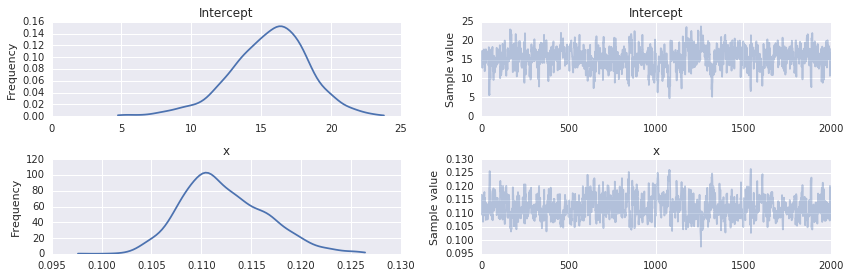

In [42]:
pm.traceplot(trace, ['Intercept', 'x']);

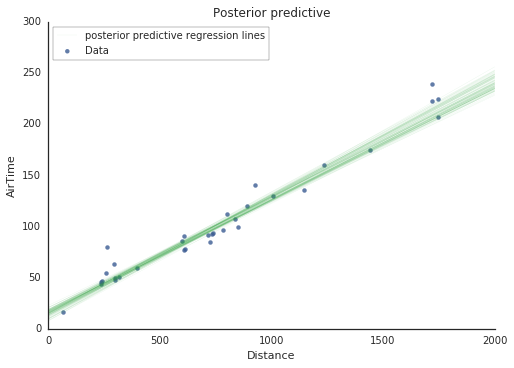

In [43]:
sns.set(style='white')

ax = sns.regplot(data=local, x='Distance', y='AirTime',
                 fit_reg=False, color=sns.xkcd_rgb["denim blue"], label="Data")

ax.set_xlim(0, 2000)
ax.set_ylim(0, 300)

x_sample = np.linspace(0, 2000, 2)

pm.glm.plot_posterior_predictive(trace[:1500], samples=100, eval=x_sample,
                                 label='posterior predictive regression lines', color=sns.xkcd_rgb["medium green"], alpha=0.2)
sns.despine()

ax.legend(loc='upper left', frameon=True)

plt.show()